A simple Pytorch code for Bayesian PINN using HMC. The governing equation is
$0.01u_{xx} = f$, where $u = \sin^3(6x)$.

To install hamiltorch, type
```
pip install git+https://github.com/AdamCobb/hamiltorch
```
in your terminal.

In [1]:
pip install git+https://github.com/AdamCobb/hamiltorch

  Cloning https://github.com/AdamCobb/hamiltorch to /tmp/pip-req-build-vio7az5d
  Running command git clone --filter=blob:none --quiet https://github.com/AdamCobb/hamiltorch /tmp/pip-req-build-vio7az5d
  Resolved https://github.com/AdamCobb/hamiltorch to commit ec972d4686385f7839d8f062e6a7a13365f00174
  Preparing metadata (setup.py) ... done
  Created wheel for hamiltorch: filename=hamiltorch-0.4.1-py3-none-any.whl size=20806 sha256=c2aeb5838d2b6aa492b932dbbec0c8fbe3e9adfd84ea5a947128a9a79613aae7
  Stored in directory: /tmp/pip-ephem-wheel-cache-t99hh1s9/wheels/fe/87/94/9c0743e518e47f9ef7e6a31bbffa0a8f0463067b7146372625
Successfully built hamiltorch


In [2]:
import torch
import hamiltorch
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import numpy as np

%matplotlib inline

In [3]:
hamiltorch.set_random_seed(123)
torch.manual_seed(123)
np.random.seed(123)
device = 'cpu'

In [4]:
def generate(num, sigma, lam1, lam2):
    # positions
    lb = -0.7
    rb = 0.7
    X = np.linspace(lb, rb, num)[:,None]
    lb, rb = np.array([[lb]]), np.array([[rb]])
    # values (could be changed if needed)
    y = lam1 * (-1.08)*np.sin(6*X)*(          #FORZANTE
        np.sin(6*X)**2-2*np.cos(6*X)**2)
    X = np.concatenate([X, lb, rb], axis = 0)   #X e in coda all'array inserisce le X dei boundary points
    y = np.concatenate([y, np.sin(6*lb) ** 3 * lam2, np.sin(6*rb) ** 3 * lam2], axis = 0)   #calcola valori forzante nelle varie X e in coda all'array inserisce valori di u nei boundary points
    y = y * (1 + sigma * np.random.randn(*y.shape))
    return X, y

In [5]:
class PoissonPINN(torch.nn.Module):
    def __init__(self, width, lam1, lam2):
        super(PoissonPINN, self).__init__()
        self.fnn = nn.Sequential(
            nn.Linear(1, width),
            nn.Tanh(),
            nn.Linear(width, width),      #deifnisce 1 input layer, 1 hidden layer e 1 ouput layer
            nn.Tanh(),
            nn.Linear(width, 1)
        )
        self.lam1 = lam1
        self.lam2 = lam2

    def forward(self, X):
        x = X[:-2].requires_grad_(True)
        u = self.fnn(x)
        u_x = torch.autograd.grad(u, x, grad_outputs = torch.ones_like(u), create_graph = True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs = torch.ones_like(u), create_graph = True)[0]
        u_bd = self.fnn(X[-2:])
        return torch.cat([u_xx * self.lam1 * 0.01, u_bd * self.lam2], dim = 0)

In [6]:
width = 50
sigma = 0.01
lam1 = 1/sigma
lam2 = 1/sigma
net = PoissonPINN(width, lam1, lam2)
for param in net.parameters():
    torch.nn.init.normal_(param)

In [7]:
train_num = 16
test_num = 100

X_train, y_train = generate(train_num, sigma, lam1, lam2)
X_test, y_test = generate(test_num, 0, lam1, lam2)
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [8]:
tau_list = [] #qui ci saranno tanti uni quanti sono i parametri nella NN
tau = 1.#/100. # iris 1/10
for w in net.parameters():
    tau_list.append(tau)
tau_list = torch.tensor(tau_list).to(device)

In [9]:
params_init = hamiltorch.util.flatten(net).to(device).clone()

# May need to tune step_size and L to make sure acceptance rate is around 0.5-0.8
step_size = 0.0006
burn = 2000
num_samples = 5000
L = 6
params_hmc = hamiltorch.sample_model(net, X_train, y_train, model_loss='regression', params_init=params_init, num_samples=num_samples,
                                     step_size=step_size, burn = burn, num_steps_per_sample=L,tau_list=tau_list, tau_out=1)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec

Acceptance Rate 0.60


In [10]:
y_pred_list = []
for i in range(num_samples - burn):
    params = hamiltorch.util.unflatten(net, params_hmc[i])
    hamiltorch.util.update_model_params_in_place(net, params)
    y_pred = net(X_test)[:-2]
    y_pred_list.append(y_pred)
y_pred = torch.stack(y_pred_list)

In [11]:
y_mean = torch.mean(y_pred, dim = 0)
y_std = torch.std(y_pred, dim = 0)
y_up, y_low = y_mean - 2 * y_std, y_mean + 2 * y_std

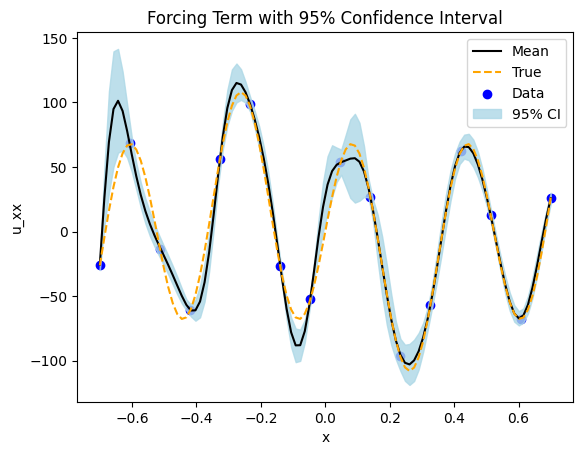

In [13]:
# Mean of predictions
plt.plot(X_test[:-2].squeeze().detach().cpu().numpy(), y_mean.detach().cpu().numpy(), label='Mean', color='black')

# True values
plt.plot(X_test[:-2].squeeze().detach().cpu().numpy(), y_test[:-2].detach().cpu().numpy(), label='True', color='orange', linestyle='--')

# Data points
plt.scatter(X_train[:-2].squeeze().detach().cpu().numpy(), y_train[:-2].detach().cpu().numpy(), label='Data', color='blue')

# Confidence Interval (CI) shading
plt.fill_between(X_test[:-2].squeeze().detach().cpu().numpy(),
                 (y_mean - 2 * y_std).squeeze().detach().cpu().numpy(),
                 (y_mean + 2 * y_std).squeeze().detach().cpu().numpy(),
                 alpha=0.8, color='lightblue', label='95% CI')

# Labels and Legend
plt.legend()
plt.ylabel('u_xx')
plt.xlabel('x')
plt.title('Forcing Term with 95% Confidence Interval')
plt.show()



In [14]:
u_pred_list = []
for i in range(num_samples - burn):
    params = hamiltorch.util.unflatten(net, params_hmc[i])
    hamiltorch.util.update_model_params_in_place(net, params)
    u_pred = net.fnn(X_test)[:-2]
    u_pred_list.append(u_pred)
u_pred = torch.stack(u_pred_list)

In [15]:
u_mean = torch.mean(u_pred, dim = 0)
u_std = torch.std(u_pred, dim = 0)
u_up, u_low = u_mean - 2 * u_std, u_mean + 2 * u_std

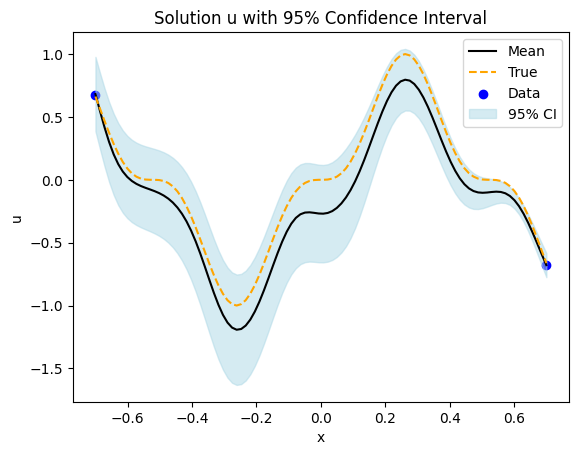

In [16]:
# Plot the mean prediction
plt.plot(X_test[:-2].detach().cpu().numpy(), u_mean.detach().cpu().numpy(), label='Mean', color='black')

# Plot the true values
plt.plot(X_test[:-2].detach().cpu().numpy(), np.sin(X_test[:-2]*6)**3, label='True', color='orange', linestyle='--')

# Scatter plot for the observed data points
plt.scatter(X_train[-2:].detach().cpu().numpy(), y_train[-2:].detach().cpu().numpy()/lam2, label='Data', color='blue')

# Ensure u_low and u_up are one-dimensional
u_low_1d = u_low.squeeze().detach().cpu().numpy()
u_up_1d = u_up.squeeze().detach().cpu().numpy()

# Confidence Interval (CI) shading with a darker shade
plt.fill_between(X_test[:-2].squeeze().detach().cpu().numpy(),
                 u_low_1d,
                 u_up_1d,
                 alpha=0.5,  # Use a darker shade by increasing alpha
                 color='lightblue',
                 label='95% CI')

# Add labels and legend
plt.legend()
plt.ylabel('u')
plt.xlabel('x')
plt.title('Solution u with 95% Confidence Interval')
plt.show()

